# Inference of Anomaly Cross Correlation skill in multi-year hindcast evaluation

A demonstration using synthetic, independent (AR) "hindcast" and "observed" series.

**Please chime in at any point**

In [1]:
import dask

import numpy as np

import xarray as xr

import matplotlib

import matplotlib.pyplot as plt

from src import utils, plot, stats, ar_model

In [2]:
matplotlib.rcParams["figure.figsize"] = (14, 6)
matplotlib.rcParams["font.size"] = 12

_ = dask.config.set(**{"array.slicing.split_large_chunks": False})

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
DATA_DIR = "../../data/processed"

## We construct some synthetic series by fitting an Autoregressive model to a climate index calculated from reanalysis data. 

E.g. let's focus on the Boreal Winter Atlantic multidecadal variability (AMV) index computed from HadISST

In [42]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = utils.calculate_period_AMV_index(
    HadISST["sst"],
    [12, 1, 2, 3],
).compute()
AMV = utils.get_observation_rolling_mean(AMV, [1, 4, 8])

In [5]:
HadSLP = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = utils.calculate_period_NAO_index(
    HadSLP["slp"],
    [12, 1, 2, 3],
).compute()
NAO = utils.get_observation_rolling_mean(NAO, [1, 4, 8])

The synthetic observations are generated by randomly drawing $N_{time}$ samples of the AR model

The synthetic ensemble hindcasts are generated by running the model forward in time from $N_{time}$ randomly drawn samples of the AR model. The initial condition for each $N_{member}$ ensemble member is the same, but their trajectories differ because the noise component is different for each member.

Below, I generate $N_{sample}=5000$ pairs of such signals

In [43]:
N_time = 200
N_samples = 5000
N_members = 200
rolling_means = [4, 8]

CPU times: user 1min 52s, sys: 5.54 s, total: 1min 57s
Wall time: 1min 57s


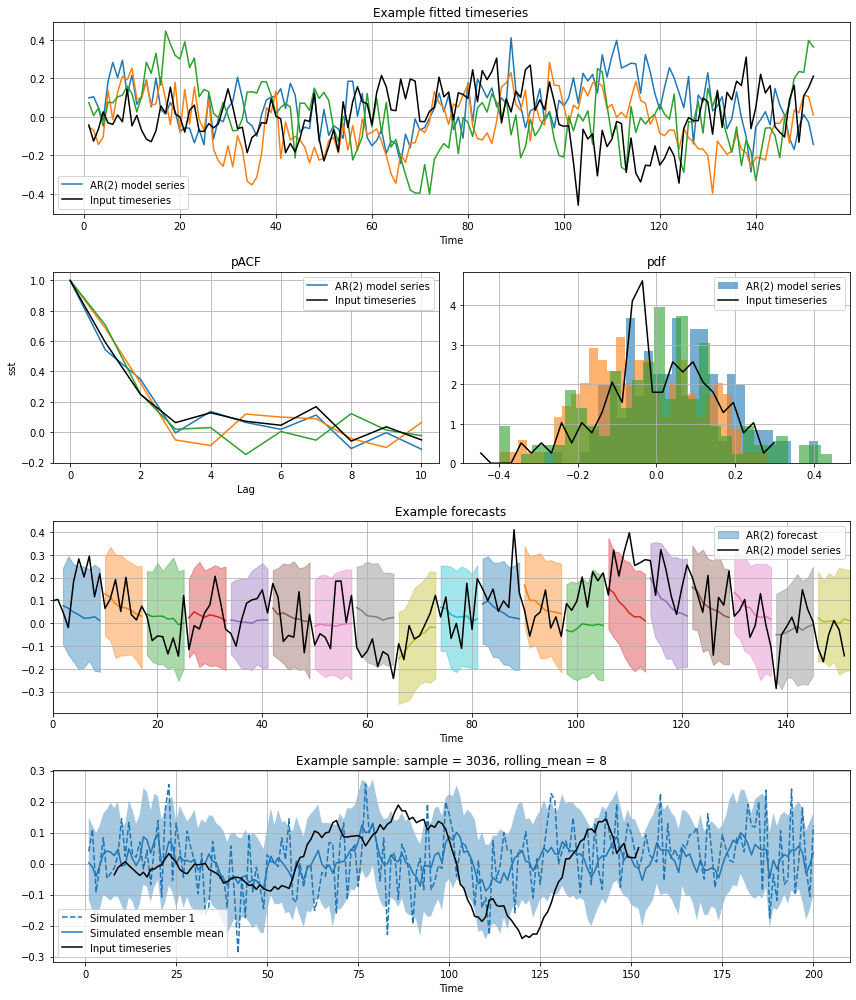

In [46]:
%%time

input_data = AMV.sel(rolling_mean=1).astype("float32")

fcst = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=N_time,
    n_samples=N_samples,
    n_members=N_members,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

obsv = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=N_time,
    n_samples=N_samples,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)

Let's focus for now on 8-year mean quantities, which is commonplace in the literature. 

Note, means are computed in a rolling fashion along **time** for the synthetic observations and along **lead** for the synthetic hindcasts.

## A common approach that has emerged for inferring the significance of skill metrics in the multi-year community is a block-bootstrapping approach using a fixed blocksize, $L$, of 5 points:

1. Randomly sample with replacement $N_{time}$ validation cases. To take autocorrelation into account, this is done in blocks of five consecutive cases.

2. For each case, randomly sample with replacement $N_{member}$ ensemble members.

3. Compute the required statistic for the ensemble mean (here we're interested in the ACC).

4. Repeat steps (1)–(3) $N_{iteration}$ times to create a probability distribution.

5. Obtain the significance level on the basis of a two-tailed test of the hypothesis that skill (ACC) is 0.

Let's do this for one of our pairs of synthetic observations/hindcasts with $N_{time}$ = 45 and $N_{member}$ = 40 (typical values)

In [24]:
N_time = 45
N_member = 200
sample = 639

In [22]:
rr, pval = stats.infer_metric(
    fcst.sel(time=slice(N_time), member=slice(N_member - 1), rolling_mean=8),
    obsv.sel(time=slice(N_time), rolling_mean=8),
    metric="pearson_r",
    method="bootstrap",
    method_kwargs=dict(
        blocks={"time": 5, "member": 1}, n_iteration=1000, transform="Fisher_z"
    ),
)

In [23]:
abs(pval.where(rr > 0) - 0.03).argmin()

<xarray.DataArray ()>
array(639)
Coordinates:
    rolling_mean  int64 8

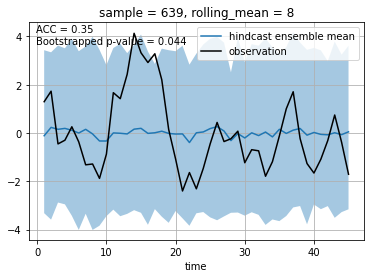

In [25]:
fcst_samp = fcst.sel(
    time=slice(N_time), member=slice(N_member - 1), rolling_mean=8, sample=sample
)
fcst_plot = fcst_samp - fcst_samp.mean(["time", "member"])
obsv_samp = obsv.sel(time=slice(N_time), rolling_mean=8, sample=sample)
obsv_plot = obsv_samp - obsv_samp.mean("time")

plt.fill_between(
    fcst_plot.time.values,
    fcst_plot.quantile(0.05, dim="member"),
    fcst_plot.quantile(0.95, dim="member"),
    color="C0",
    edgecolor="none",
    alpha=0.4,
)
(1 * fcst_plot.mean("member")).plot(color="C0", label="hindcast ensemble mean")
obsv_plot.plot(color="k", label="observation")

r, p = stats.infer_metric(
    fcst_samp,
    obsv_samp,
    metric="pearson_r",
    method="bootstrap",
    method_kwargs=dict(
        blocks={"time": 5, "member": 1}, n_iteration=1000, transform="Fisher_z"
    ),
)
plt.text(
    0.02,
    0.90,
    f"ACC = {r.values:.2f}\nBootstrapped p-value = {p.values:.3f}",
    transform=plt.gca().transAxes,
)

plt.grid()
_ = plt.legend(loc="upper right")

Most multi-year verification studies assign significance for p-values less than 0.05, so for this sample, we would say that our hindcasts are skillful. 

Of course, it's not surprising that I can find examples of high correlation in my $N_{sample}$s of synthetic signals. However, the p-value estimated by the "standard" block bootstrap approach is far too low. Actually, correlations this high occur far more often than this p-value suggests.

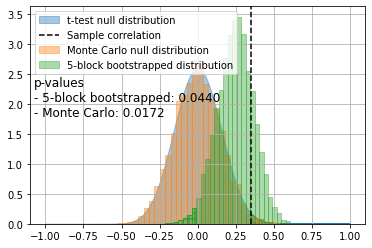

In [26]:
plot.pearson_r_distributions(
    fcst.sel(time=slice(N_time), member=slice(N_member - 1), rolling_mean=8),
    obsv.sel(time=slice(N_time), rolling_mean=8),
    sample,
    block=5,
)

This is because the serial correlation is high due to:

1. The nature of the process being assessed
2. The 8-year averaging (largest effect on the observations)
3. The ensemble averaging

The effective sample size is very small and a blocksize of 5 is insufficient to account for the autocorrelation.

## Let's see how the Type I error rates (i.e. the proportion of samples that reject the null hypothesis when it's actually true) at $\alpha = 0.05$ depend on $N_{time}$ and $N_{member}$.

In [37]:
%%time
clobber = True

if clobber:
    T1_er, r_crit = stats.get_Type_I_error_rates(
        fcst.sel(rolling_mean=8),
        obsv.sel(rolling_mean=8),
        n_times=[45], #np.logspace(np.log10(15), np.log10(200), 15).astype(int),
        n_members=np.logspace(np.log10(5), np.log10(200), 10).astype(int),
        metric="pearson_r",
        method="bootstrap",
        method_kwargs=dict(
            blocks={"time": 5, "member": 1}, n_iteration=1000, transform="Fisher_z"
        ),
        alpha=0.05,
        sample_blocks=200,
    )
    
    T1_er.to_dataset(name="T1_er").to_netcdf(
        f"{DATA_DIR}/amv_T1error.nc",
        mode="w"
    )
    r_crit.to_dataset(name="r_crit").to_netcdf(
        f"{DATA_DIR}/amv_rcrit.nc",
        mode="w"
    )
else:
    T1_er = xr.open_dataset(
        f"{DATA_DIR}/amv_T1error.nc"
    )["T1_er"]
    r_crit = xr.open_dataset(
        f"{DATA_DIR}/amv_rcrit.nc"
    )["r_crit"]

Processing Nt=45, Nm=5
Processing Nt=45, Nm=7
Processing Nt=45, Nm=11
Processing Nt=45, Nm=17
Processing Nt=45, Nm=25
Processing Nt=45, Nm=38
Processing Nt=45, Nm=58
Processing Nt=45, Nm=88
Processing Nt=45, Nm=132
Processing Nt=45, Nm=200
CPU times: user 3min 37s, sys: 1min 56s, total: 5min 33s
Wall time: 5min 33s


In [38]:
T1_er

<xarray.DataArray (n_times: 1, n_members: 10)>
array([[0.0164, 0.0146, 0.0142, 0.0208, 0.028 , 0.0408, 0.0598, 0.0804,
        0.0946, 0.1118]])
Coordinates:
    rolling_mean  int64 8
  * n_members     (n_members) int64 5 7 11 17 25 38 58 88 132 200
  * n_times       (n_times) int64 45

In [35]:
T1_er

<xarray.DataArray (n_times: 1, n_members: 10)>
array([[0.0108, 0.0088, 0.0094, 0.0084, 0.0098, 0.0102, 0.0148, 0.022 ,
        0.0312, 0.0418]])
Coordinates:
    rolling_mean  int64 8
  * n_members     (n_members) int64 5 7 11 17 25 38 58 88 132 200
  * n_times       (n_times) int64 45

In [32]:
T1_er

<xarray.DataArray (n_times: 1, n_members: 10, rolling_mean: 3)>
array([[[0.0154, 0.0138, 0.0106],
        [0.0142, 0.0104, 0.0102],
        [0.0154, 0.0078, 0.008 ],
        [0.0114, 0.008 , 0.0072],
        [0.0148, 0.0074, 0.006 ],
        [0.017 , 0.0082, 0.0068],
        [0.0204, 0.0134, 0.008 ],
        [0.0246, 0.0114, 0.008 ],
        [0.0268, 0.0152, 0.0078],
        [0.036 , 0.0184, 0.0088]]])
Coordinates:
  * rolling_mean  (rolling_mean) int64 1 4 8
  * n_members     (n_members) int64 5 7 11 17 25 38 58 88 132 200
  * n_times       (n_times) int64 45

In [28]:
T1_er

<xarray.DataArray (n_times: 1, n_members: 10, rolling_mean: 3)>
array([[[0.0126, 0.01  , 0.0102],
        [0.0122, 0.0098, 0.0092],
        [0.0128, 0.0082, 0.0072],
        [0.0106, 0.0096, 0.0054],
        [0.0086, 0.0058, 0.0064],
        [0.0102, 0.0066, 0.0072],
        [0.009 , 0.0058, 0.0064],
        [0.0098, 0.0068, 0.0062],
        [0.0074, 0.0098, 0.0064],
        [0.0074, 0.0098, 0.0068]]])
Coordinates:
  * rolling_mean  (rolling_mean) int64 1 4 8
  * n_members     (n_members) int64 5 7 11 17 25 38 58 88 132 200
  * n_times       (n_times) int64 45

In [29]:
T1_er.sel(rolling_mean=8)

<xarray.DataArray (n_times: 1, n_members: 10)>
array([[0.0102, 0.0092, 0.0072, 0.0054, 0.0064, 0.0072, 0.0064, 0.0062,
        0.0064, 0.0068]])
Coordinates:
    rolling_mean  int64 8
  * n_members     (n_members) int64 5 7 11 17 25 38 58 88 132 200
  * n_times       (n_times) int64 45

## Things I'm exploring/battling with:
1.  I'm struggling a little to come up with a nice, convincing story that uses synthetic series. I have a strong suspicion that the situation is actually worse than my model fits to a given index would suggest. For example, it would be great to touch on the NAO, which has received a lot of attention around the signal-to-noise paradox.


## Things I'm exploring/battling with:
 - I'm struggling a little to come up with a nice, convincing story that uses synthetic series. I have a strong suspicion that the situation is actually worse than my model fits to a given index would suggest. I'm worred people may not be convinced by synthetic timeseries...
 - 

Things to explore:
- Is there a blocksize that is appropriate? Is it preventitively large?
- Can we provide an alternative way forward? How do different significance tests perform?
- Can we usefully quantify the impact of trends which are often not removed?
- What do the results mean for the signal-to-noise paradox?
- How sensitive are other metrics? e.g MSE?

## How do the autocorrelation functions of our simulated series compare to real (detrended) AMV hindcasts?

In [32]:
HadGEM3 = xr.open_zarr(
    f"{DATA_DIR}/tos_Omon_HadGEM3-GC31-MM_dcpp.zarr", use_cftime=True
)
AMV_HadGEM3 = utils.calculate_period_AMV_index(
    HadGEM3["tos"],
    [12, 1, 2, 3],
).compute()
AMV_HadGEM3 = utils.get_hindcast_mean(
    AMV_HadGEM3, mean_lead_range=[(1, 2), (1, 5), (1, 9)]
).dropna("time")

In [33]:
ECEarth3 = xr.open_zarr(f"{DATA_DIR}/tos_Omon_EC-Earth3_dcpp.zarr", use_cftime=True)
AMV_ECEarth3 = utils.calculate_period_AMV_index(
    ECEarth3["tos"],
    [12, 1, 2, 3],
).compute()
AMV_ECEarth3 = utils.get_hindcast_mean(
    AMV_ECEarth3, mean_lead_range=[(1, 2), (1, 5), (1, 9)]
).dropna("time")

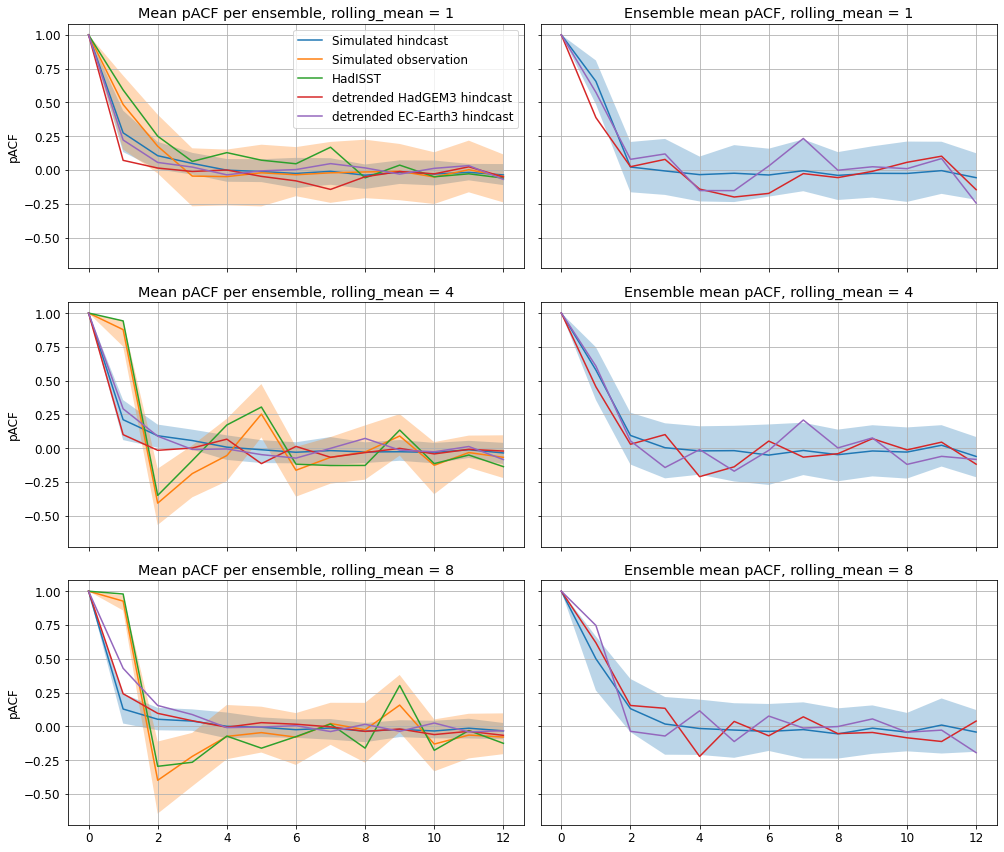

In [80]:
plot.acf(
    fcst.isel(
        member=range(AMV_HadGEM3.sizes["member"]), time=range(AMV_HadGEM3.sizes["time"])
    ),
    obsv.isel(time=range(AMV_HadGEM3.sizes["time"])),
    AMV,
    utils.detrend(AMV_HadGEM3),
    utils.detrend(AMV_ECEarth3),
    headings=[
        "Simulated hindcast",
        "Simulated observation",
        "HadISST",
        "detrended HadGEM3 hindcast",
        "detrended EC-Earth3 hindcast",
    ],
    partial=True,
    nlags=12,
)

## What is the effective sample size? Is there a blocksize that produces reasonable Type 1 error rates?

The effective sample size for a 45-year 8-year mean series estimated by:

$ N_{eff} = N \frac{1 - \rho_{f} \rho_{o}}{1 + \rho_{f} \rho_{o}} $

where  and  are the lag-1 autocorrelation coefficients for the forecasts and observations (Bretherton et al. [1991]) is:



In [83]:
N_time = 45
N_members = 40

fcst_long = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=1000,
    n_samples=1000,
    n_members=N_members,
    rolling_means=[8],
    plot_diagnostics=False,
).sel(rolling_mean=8)

obsv_long = ar_model.generate_samples_like(
    input_data,
    order="select_order",
    n_times=1000,
    n_samples=1000,
    rolling_means=[8],
    plot_diagnostics=False,
).sel(rolling_mean=8)

Neff = stats.effective_sample_size(
    fcst.isel(time=slice(N_time), member=slice(N_member))
    .sel(rolling_mean=8)
    .mean("member"),
    obsv.isel(time=slice(N_time)).sel(rolling_mean=8),
)
Neff_long = stats.effective_sample_size(fcst_long.mean("member"), obsv_long, N_time)

print(
    f"Using N_time=45 to estimate autocorrelation: N_eff = {Neff.mean('sample').values:.1f} (std = {Neff.std('sample').values:.1f})"
)
print(
    f"Using N_time=1000 to estimate autocorrelation: N_eff = {Neff_long.mean('sample').values:.1f} (std = {Neff_long.std('sample').values:.1f})"
)

Using N_time=45 to estimate autocorrelation: N_eff = 9.0 (std = 3.9)
Using N_time=1000 to estimate autocorrelation: N_eff = 8.0 (std = 0.8)


The estimated blocksize, $L$, estimated by Wilks is (assuming the data follow a first-order regressive process):

$ L = (N - L + 1)^{\frac{2}{3} \left( 1 - \frac{N_{eff}}{N} \right)}  $

In [77]:
print(f"L = {stats.blocklength_Wilks(45, 8)}")

L = 7


Using a blocksize of 7 makes very little difference the above results